<a href="https://colab.research.google.com/github/aldencabajar/kaggle-m5-comp-scripts/blob/master/m5_nn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import gc
calendar = pd.read_csv("drive/My Drive/calendar.csv")
sales = pd.read_csv("drive/My Drive/sales_train_evaluation.csv")
print("calendar shape:" , calendar.shape, "\nsales shape:", sales.shape)

calendar shape: (1969, 14) 
sales shape: (30490, 1947)


In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [ ]:
reduce_mem_usage(calendar)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%


In [ ]:
from tqdm import tqdm
days_col = sales.columns[sales.columns.str.contains(r'd_\d*')] 
def ts_agg(df, grp, i):
    if 'X' in grp and 'Total' not in grp:
        agg_col = grp[np.where(np.array(grp) != 'X')[0][0]]
        fn = df[np.append(agg_col, days_col)].set_index(agg_col).groupby(agg_col).apply(sum).reset_index()
        fn['id2'] = 'X'
        fn['id'] = fn[np.array([agg_col, 'id2'])].apply(lambda x: '_'.join(x), axis = 1).values
        #fn.drop([agg_col, 'id2'], inplace = True, axis = 1)
        
    elif 'Total' in grp:
        df['id'] = 'Total_X'
        fn = df[np.append('id', days_col)].set_index('id').groupby('id').apply(sum).reset_index()
        
        
    else:
        fn = df[np.append(grp, days_col)].set_index(grp).groupby(grp).apply(sum).reset_index()
        fn['id'] = fn[grp].apply(lambda x: '_'.join(x), axis = 1).values
        #fn.drop(grp, inplace = True, axis = 1)
    
    fn['lvl'] = i 
        
    return(fn)
### DETERMINE AGGREGATED SALES ####
levels = (['Total','X'], ['state_id', 'X'], ['store_id', 'X'], ['cat_id', 'X'], ['dept_id', 'X'], 
          ['state_id', 'cat_id'], ['state_id', 'dept_id'], ['store_id', 'cat_id'], ['store_id', 'dept_id'], 
          ['item_id', 'X'], ['state_id', 'item_id'], ['item_id', 'store_id'])

agg_sales_list = []
for i, lv in tqdm(enumerate(levels)):
    agg_sales_list.append(ts_agg(sales, lv, i + 1))


12it [00:36,  3.02s/it]


In [ ]:
agg_sales_all = pd.concat(agg_sales_list)

Add dummy sales columns (from day 1942 to 1969) to facilitate creation of evaluation days features 

In [ ]:
d_cols_eval = ['d_' + str(i) for i in range(1942, 1970)] 
for d in d_cols_eval:
  agg_sales_all[d] = np.nan 

In [ ]:
from datetime import datetime
import gc
def create_dataset(start_day, lags):
  days_col = agg_sales_all.columns[
  agg_sales_all.columns.str.contains(r'd_\d*')]

  # determine the minimum day when sales was non-zero  
  agg_sales_all['min_day_sales'] = agg_sales_all.loc[:,days_col] \
  .apply(lambda x: np.min(np.where(x > 0)[0] + 1), axis = 1)

  print("melting the dataset...")
  agg_melt = pd.melt(agg_sales_all.loc[:,list(days_col) + ['id', 'min_day_sales']], 
                   var_name = "day", value_name = "sales", 
                   id_vars = ['id', 'min_day_sales'])

  start_mem = agg_melt.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
  agg_melt['day'] = agg_melt['day'].str.replace('d_', '').astype(np.int16)
  agg_melt['min_day_sales'] = agg_melt['min_day_sales'].astype(np.int16)
  agg_melt['sales'] = agg_melt['sales'].astype(np.float32)
  end_mem = agg_melt.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(end_mem))

  agg_melt.sort_values(by = ["id", "day"], inplace = True)
  agg_melt.reset_index(inplace = True, drop = True)

  # calculating weights for scaling samples later on
  print('creating weights...')
  agg_melt['prev_val'] = agg_melt.groupby("id")['sales'].shift(1)
  agg_melt['abs_diff'] = np.abs(agg_melt['sales'] - agg_melt['prev_val'])
  agg_melt['wt'] = (agg_melt['day'] - 1) / agg_melt.groupby('id')['abs_diff'].cumsum()

  print( 'maximum weight:', np.nanmax(agg_melt['wt']), '\nminimum weight:', 
        np.nanmin(agg_melt['wt']))

  agg_melt = agg_melt.loc[
    (agg_melt.min_day_sales <= agg_melt.day) & (agg_melt.day >= start_day)]
  
  agg_melt['scaled'] = agg_melt['sales'] * agg_melt['wt']
  
  # create lagged variables
  print('creating lagged variables...')
  if np.any(np.array(lags) < 28):
    return(print("please pick a lagged variable greater than 28 days")) 
  else:
    for lag in lags:
      lag_name = "lag" + str(lag)
      agg_melt[lag_name] = agg_melt.groupby("id")['scaled'].shift(lag)
    # drop lagged variables with null values 
    lag_vars = agg_melt.columns[agg_melt.columns.str.contains('lag')]
    agg_melt = agg_melt.dropna(subset = lag_vars)

  # remmove unnecessary vars
  print('removing unnecessary variables...')
  agg_melt.drop(columns = ['min_day_sales', 'prev_val', 'abs_diff'], 
                inplace = True)
  gc.collect()


  # prepare calendar variables
  print('preparing calendar variables...')
  calendar = pd.read_csv("drive/My Drive/calendar.csv")
  reduce_mem_usage(calendar)
  calendar['date1'] = calendar.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
  calendar['start_date_year'] = calendar.year.apply(lambda x: datetime.strptime(str(x) + '-01-01', '%Y-%m-%d'))
  calendar['day_of_year'] = calendar['date1'] - calendar['start_date_year']
  calendar['day_of_year'] = calendar['day_of_year'].apply(lambda x: x.days + 1).astype(np.int16)
  calendar['d'] = calendar['d'].str.replace("d_", "").astype(np.int16)
  var_list = ['wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'day_of_year']

  # convert events to integers, can be thought of as ordinal encoding, although
  # this might not be a good way to represent it 
  event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
  calendar[event_cols] = calendar[event_cols].apply(lambda x: x.astype("category").cat.codes)

  print('merging with sales...')
  sales_calendar_merge = pd.merge(calendar[var_list], 
                                  agg_melt, right_on = "day", 
                                  left_on = "d", how = "right") \
                                  .sort_values(by =['id', 'day'], ignore_index  = True)
  sales_calendar_merge.drop(columns = ['d'], inplace=True)                                
  del agg_melt; gc.collect()
  print('dataset shape:', sales_calendar_merge.shape)


  return(sales_calendar_merge)



In [ ]:
dataset = create_dataset(start_day=1000, lags=[28, 35, 42, 49, 56])
# scale the sales by the weight
#dataset['scaled'] = dataset.sales * dataset.wt


melting the dataset...
Memory usage of dataframe is 2574.22 MB
Memory usage of dataframe is 1287.11 MB
creating weights...
maximum weight: inf 
minimum weight: 0.00017895846
creating lagged variables...
removing unnecessary variables...
preparing calendar variables...
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%
merging with sales...
dataset shape: (37513772, 21)


In [ ]:
dataset.head()


,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year,id,day,sales,wt,scaled,lag28,lag35,lag42,lag49,lag56
0,6,12,2013,-1,-1,-1,-1,0,0,0,353,CA_1_FOODS,1056,2626.0,0.002240,5.881280,5.067099,5.178451,5.609182,4.805220,4.793205
1,7,12,2013,-1,-1,-1,-1,0,0,0,354,CA_1_FOODS,1057,2674.0,0.002242,5.993849,5.824064,5.808530,6.637831,7.016936,6.369957
2,1,12,2013,-1,-1,-1,-1,0,0,0,355,CA_1_FOODS,1058,3715.0,0.002239,8.316789,8.163610,8.291222,8.190029,8.240806,8.364721
3,2,12,2013,-1,-1,-1,-1,0,0,0,356,CA_1_FOODS,1059,3729.0,0.002241,8.355781,8.249379,8.477244,9.304770,9.904868,8.683564
4,3,12,2013,-1,-1,-1,-1,0,0,0,357,CA_1_FOODS,1060,3537.0,0.002242,7.929821,6.270786,5.707453,6.875257,6.417516,6.140059


We now prepare the input data that we will be using for the train, test and validation

HOBBIES_1_075_WI_1      28
HOBBIES_2_087_X         28
FOODS_3_356_TX_2        28
HOUSEHOLD_1_151_TX_2    28
HOUSEHOLD_1_257_X       28
                        ..
HOUSEHOLD_2_350_TX_1    28
HOUSEHOLD_2_251_WI_1    28
FOODS_3_380_CA_1        28
HOUSEHOLD_2_425_WI_2    28
FOODS_3_625_X           28
Name: id, Length: 42840, dtype: int64

In [ ]:
train_data = dataset[dataset.day <= 1913]
train_data = train_data[np.isfinite(train_data.wt)]
validation_data = dataset[np.logical_and(dataset.day <= 1941, dataset.day > 1913)]
evaluation_data = dataset[np.logical_and(dataset.day > 1941, dataset.day <= 1969)]

# append last weights from validation data to evaluation data
evaluation_data.loc[:,'wt'] = np.repeat(
    validation_data[validation_data.day == 1941]['wt'].values, 28) 






/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
print('train max day:', np.max(train_data['day']),
      '\nvalidation max day:', np.max(validation_data['day']),
      '\nevaluation max day:', np.max(evaluation_data['day']))



train max day: 1913 
validation max day: 1941 
evaluation max day: 1969


In [ ]:
print('train data shape:', train_data.shape,
      '\nvalidation data shape:', validation_data.shape,
      '\nevaluation data shape:', evaluation_data.shape)


train data shape: (35114732, 21) 
validation data shape: (1199520, 21) 
evaluation data shape: (1199520, 21)


prepare one-hot encoding indices for `id` values:  

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

def one_hot_fn(id_arr, ret_vocab = False):
  unique_ids = id_arr.unique()
  len_unique_ids = id_arr.value_counts().set_axis(unique_ids).values 
  stri_split = tf.strings.split(unique_ids, sep = "_")
  vocab, idx = tf.unique(stri_split.flat_values)
  encoded_ids = [one_hot(d, tf.size(vocab).numpy()) for d in unique_ids]
  max_length = np.max([len(i) for i in encoded_ids])
  padded_encoded = np.array(pad_sequences(encoded_ids, maxlen=max_length, padding='post'))
  padded_encoded = np.repeat(padded_encoded, len_unique_ids, axis = 0)

  if ret_vocab:
    return padded_encoded, vocab 
  else:
    return padded_encoded

train_id_enc, vocab = one_hot_fn(train_data['id'], ret_vocab = True)
validation_id_enc = one_hot_fn(validation_data['id'])
eval_id_enc = one_hot_fn(evaluation_data['id'])
print(train_id_enc.shape, validation_id_enc.shape, eval_id_enc.shape)

(35114732, 5) (1199520, 5) (1199520, 5)


### Setting up neural network architecture

For this model, let us try a multi-layer perceptron with *n* hidden layers as a baseline. This is unique since we also try to incorporate an embedding layer (to represent the different ids as a dense vector) along the modelling process. 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return keras.backend.mean(v)


feat_vars = dataset.columns[~dataset.columns.isin(['id', 'sales', 'scaled', 'wt'])]

def create_model(n_hidden_layers, hidden_units):
  
  ts_id_input = layers.Input(shape = (None, ), dtype = 'int32', 
                             name =  "ts_id_input") 
  # represent vocabulary with a 16-d vector                           
  embedding = layers.Embedding(836, 100) 
  encoded_input = embedding(ts_id_input)

  # since there are ids with multiple words, average vectors into single 
  # representation of the phrase
  pooled_input = layers.GlobalAveragePooling1D()(encoded_input)
  num_input = layers.Input(shape = (feat_vars.shape[0],) , dtype = 'float32', 
                              name = 'ts_features')
  concat_layer = layers.concatenate([pooled_input, num_input])

  # involve dropout layer for regularization 
  for i in range(n_hidden_layers):
    if i < (n_hidden_layers - 1) :
      if i == 0:
        mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                          activation = 'relu')(concat_layer)
      else:
        mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                          activation = 'relu')(mod)
      mod = layers.Dropout(0.3)(mod)
      mod = layers.Concatenate(name = "ft"+str(i))([pooled_input, mod])

    elif i == (n_hidden_layers - 1):
      mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                         activation = 'relu')(mod)
  # output final dense layer with 9 outputs equal to the number of quantiles to 
  # be predicted                        
  preds = layers.Dense(9, activation="linear", name="preds")(mod)
  model = keras.Model(inputs = [ts_id_input, num_input], 
                      outputs = [preds])
  model.compile(loss=qloss, optimizer="adam")                    
  return(model)

In [ ]:
model = create_model(n_hidden_layers = 3, hidden_units = 500)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ts_id_input (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 100)    83600       ts_id_input[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_3 (Glo (None, 100)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
ts_features (InputLayer)        [(None, 17)]         0                                            
____________________________________________________________________________________________

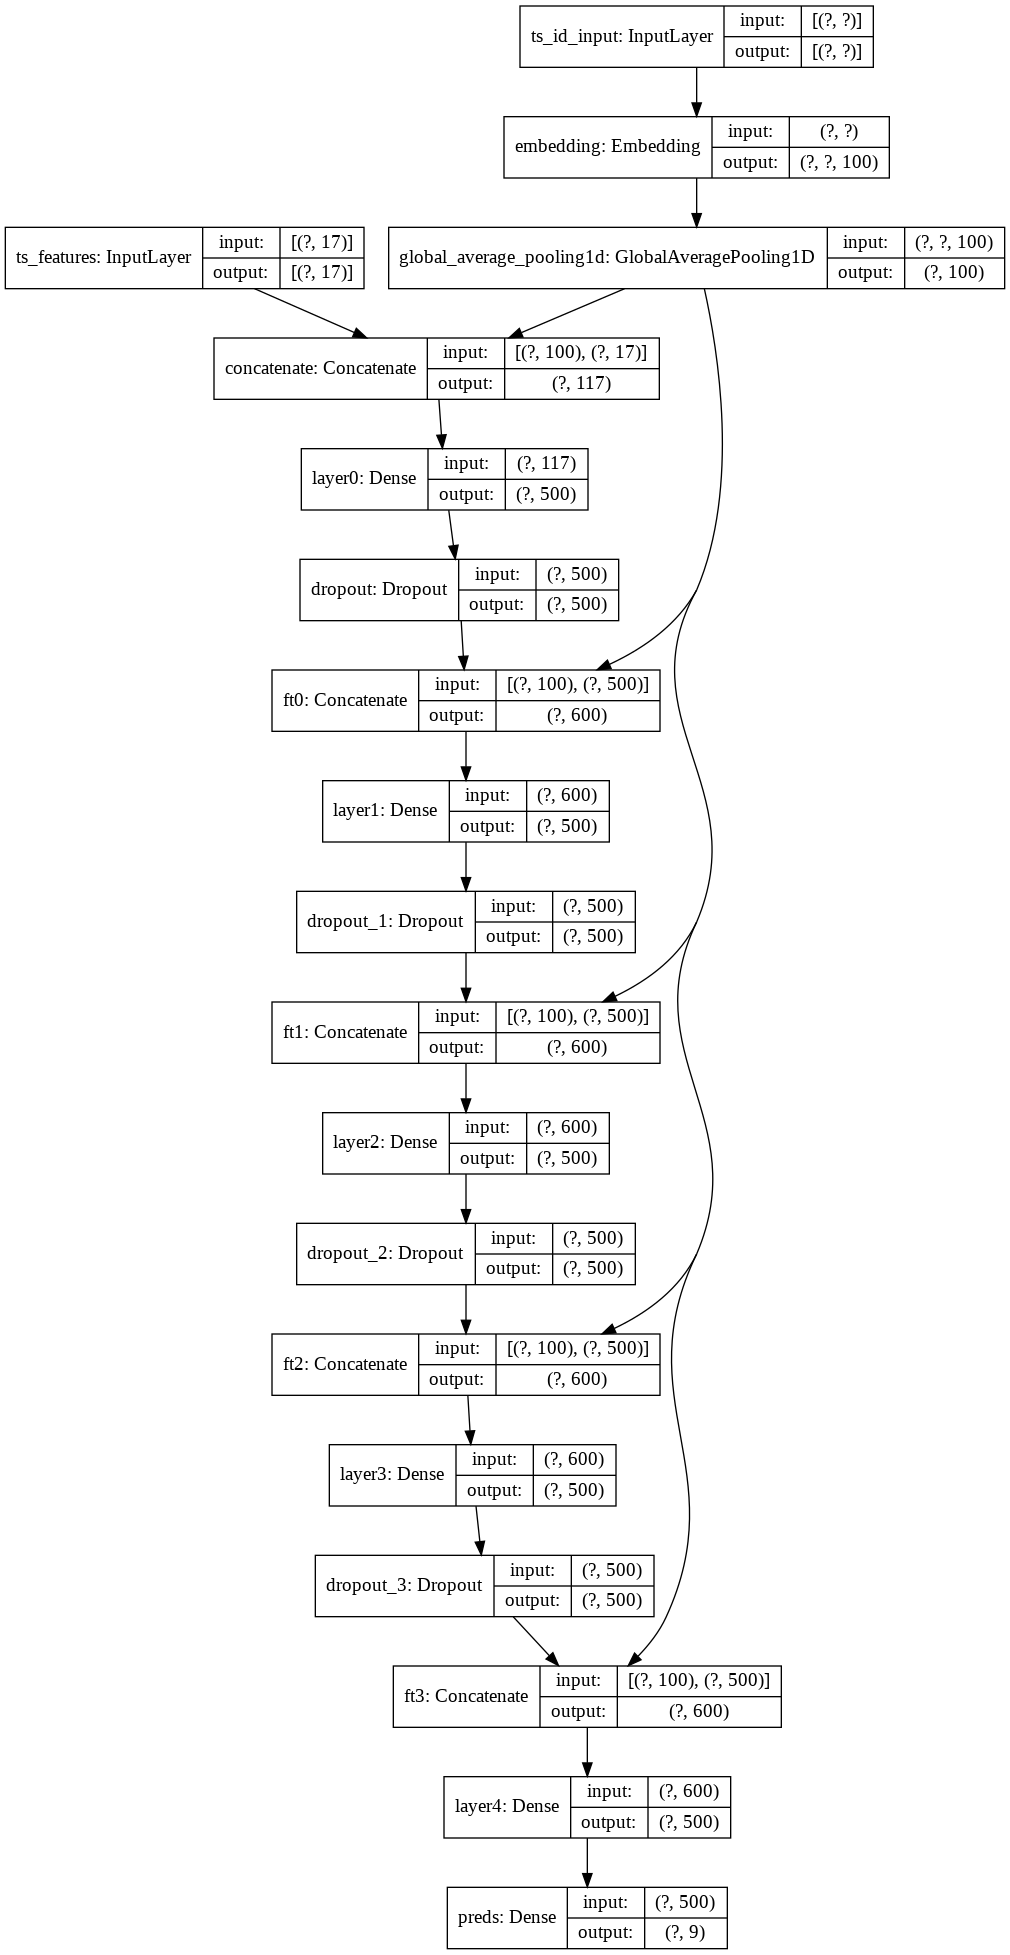

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

Defining a number of callbacks to further regulate neural network training  

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping 

ckpt = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
keras.backend.clear_session()
train_data_dict = {'ts_id_input': train_id_enc, 
                   'ts_features':train_data[feat_vars]}
val_data_dict = {'ts_id_input': validation_id_enc, 
                 'ts_features': validation_data[feat_vars]}
                 
history = model.fit(x = train_data_dict, y = train_data['scaled'].values, 
          validation_data = (val_data_dict, validation_data['scaled'].values), 
          batch_size = 120_000, epochs = 20, callbacks = [ckpt, reduce_lr, es])
          

Epoch 1/20
293/293 [==============================] - ETA: 0s - loss: 1.3997
Epoch 00001: val_loss improved from inf to 0.40337, saving model to weights.h5
293/293 [==============================] - 64s 219ms/step - loss: 1.3997 - val_loss: 0.4034 - lr: 0.0010
Epoch 2/20
293/293 [==============================] - ETA: 0s - loss: 0.4813
Epoch 00002: val_loss improved from 0.40337 to 0.39436, saving model to weights.h5
293/293 [==============================] - 64s 219ms/step - loss: 0.4813 - val_loss: 0.3944 - lr: 0.0010
Epoch 3/20
293/293 [==============================] - ETA: 0s - loss: 0.4705
Epoch 00003: val_loss improved from 0.39436 to 0.39371, saving model to weights.h5
293/293 [==============================] - 64s 218ms/step - loss: 0.4705 - val_loss: 0.3937 - lr: 0.0010
Epoch 4/20
293/293 [==============================] - ETA: 0s - loss: 0.4668
Epoch 00004: val_loss did not improve from 0.39371
293/293 [==============================] - 64s 219ms/step - loss: 0.4668 - val_lo

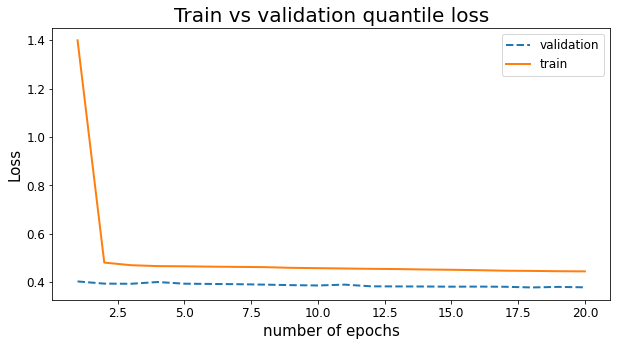

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
history_dict = history.history 
mean_q_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, figsize = (10, 5))
epochs = list(range(1, len(mean_q_loss) + 1))
ax.plot(epochs, validation_loss, linestyle = '--', linewidth = 2,
        label = "validation")
ax.plot(epochs, mean_q_loss, linewidth = 2, label = "train")
ax.set_xlabel('number of epochs', size = 15)
ax.set_ylabel('Loss', size = 15)
#ax.set_ylim([0, np.max(np.append(mean_q_loss, validation_loss))])
ax.legend()
plt.title('Train vs validation quantile loss', size = 20)
plt.show()


In [ ]:
fnl = create_model(3, 500)
fnl.load_weights("weights.h5")

In [ ]:
eval_data_dict = {'ts_id_input': eval_id_enc, 
                   'ts_features':evaluation_data[feat_vars]}


val_preds = fnl.predict(val_data_dict, batch_size = 50_000) 
eval_preds = fnl.predict(eval_data_dict, batch_size = 50_000) 

print(val_preds.shape, eval_preds.shape)

(1199520, 9) (1199520, 9)


In [ ]:
val_preds = val_preds.reshape((-1, 28, 9))
eval_preds = eval_preds.reshape((-1, 28, 9))

print(val_preds.shape, eval_preds.shape)

(42840, 28, 9) (42840, 28, 9)


In [ ]:
val_preds[:, :, 0].transpose()

In [ ]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]

ids = validation_data['id'].unique()
d_cols =  ['F' + str(i) for i in range(1, 29)]

validation = []
evaluation = []
wts = validation_data[validation_data.day == 1941].wt.values.reshape(-1, 1) 

for i, qt in enumerate(QUANTILES):
  val_tmp = pd.DataFrame(val_preds[:, :, i]/wts, columns = d_cols)
  eval_tmp = pd.DataFrame(eval_preds[:, :, i]/wts, columns = d_cols)
  eval_tmp['id'] = ['_'.join([id, qt, 'evaluation']) for id in ids] 
  val_tmp['id'] = ['_'.join([id, qt, 'validation']) for id in ids] 
  validation.append(val_tmp)
  evaluation.append(eval_tmp)


validation_preds = pd.concat(validation).sort_values(by = 'id')
evaluation_preds = pd.concat(evaluation).sort_values(by = 'id')
submission = pd.concat([validation_preds, evaluation_preds])
submission.to_csv('submission.csv', index=False)



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions submit -c m5-forecasting-uncertainty -f submission.csv -m "using mlp deep learning"

100% 254M/254M [00:12<00:00, 20.9MB/s]
Successfully submitted to M5 Forecasting - Uncertainty

In [ ]:
!kaggle competitions download m5-forecasting-uncertainty

401 - Unauthorized


In [ ]:
!rm -rf .kaggle
